# MAT003 Introduction to machine learning Group Project

#### Group 4   
members: Xiao'ao Song(18-747-949)  Weiyi Wang(19-764-786)

## Import packages

In [2]:
import pandas as pd
import numpy as np
import numpy
import math
import time
from math import floor
import operator
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
# from sklearn.neural_network import MLPClassifier
# from sklearn.model_selection import cross_val_score
from sklearn import svm
#from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import KFold
# from sklearn.utils import class_weight

# np.random.seed(seed=167)
import warnings
warnings.filterwarnings("ignore")

## Load dataset

In [3]:
data_set = pd.read_csv('/Users/wwyvette/Desktop/ML/exam/dataset4.csv',header=0,index_col = None,sep=';')

## Dataset description and analysis
After loading the data set, we first have a rough check on the data set.

In [4]:
data_set.head(3)

,radio_play,tonality,ratings,albums_sold,loudness,tempo,song_id,vocals,listen_count,length,instr,frequency,year,class
0,3.214737,minor,medium,1.808823,0.495750,44.219950,YR42138,0.542255,14.651154,0.754471,2.004861,8.895517,14.124177,1
1,2.714995,major,medium,2.570554,1.179683,89.727501,YR20543,0.286127,21.862053,3.257507,2.342440,1.410923,13.088463,0
2,3.344488,atonal,medium,2.539966,0.878841,98.620555,YR38837,0.318834,15.068252,0.501357,2.563865,3.069557,12.353221,2


In [5]:
Counter(data_set['class'])

Counter({1: 162, 0: 172, 2: 165})

**The classes are well balanced**, therefore, we **do not** need to handle the class imbalance issue in this project.

In [6]:
Counter(data_set['ratings'])

Counter({'medium': 340, 'high': 92, 'low': 67})

In [7]:
Counter(data_set['tonality'])

Counter({'minor': 140, 'major': 200, 'atonal': 159})

The feature "tonality" and "ratings" have **string values**.

## abnormal value check

In [8]:
np.where(data_set['length']<=0)

(array([  3,   6,  23,  50,  66,  79, 102, 112, 122, 136, 138, 144, 195,
        198, 213, 219, 222, 225, 227, 229, 231, 236, 245, 254, 261, 268,
        271, 278, 281, 290, 292, 321, 356, 369, 388, 391, 392, 393, 394,
        397, 400, 404, 418, 426, 433, 462, 470, 471, 476, 478, 494, 496]),)

In [9]:
np.where(data_set['vocals']<=0)

(array([186]),)

In [10]:
data_set.iloc[186,:]

radio_play       3.82196
tonality          atonal
ratings           medium
albums_sold      2.39713
loudness        0.878012
tempo            100.857
song_id          YR37003
vocals         -0.125632
listen_count     13.9333
length          0.134628
instr            2.47379
frequency        3.08821
year             12.6334
class                  2
Name: 186, dtype: object

In [11]:
np.where(data_set['year']<=0)

(array([], dtype=int64),)

In [12]:
np.where(data_set['radio_play']<=0)

(array([ 45, 127, 151, 163, 168, 237, 252, 270, 300, 308, 377, 399, 476,
        483]),)

In [13]:
np.where(data_set['frequency']<=0)

(array([143, 148, 193, 319, 357, 360, 366, 482]),)

Although in real case, we need to handle these abnormal entries, however, since in this project, the data is created artifically, we do not know the mechanism of how they are generating. Thus it is ok to not handle those entries that are abnormal in real life.

## missing value check

In [14]:
data_set.isnull().sum()

radio_play      0
tonality        0
ratings         0
albums_sold     0
loudness        6
tempo           0
song_id         0
vocals          0
listen_count    0
length          0
instr           0
frequency       3
year            0
class           0
dtype: int64

In [15]:
np.where(data_set['loudness'].isnull())

(array([125, 198, 224, 266, 276, 384]),)

In [16]:
np.where(data_set['frequency'].isnull())

(array([131, 156, 408]),)

## duplicate value check

In [17]:
# x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
res = Counter(data_set['song_id'])
sorted_res = sorted(res.items(), key=operator.itemgetter(1))
sorted_res[-10:]

[('YR71475', 1),
 ('YR27185', 1),
 ('YR96522', 1),
 ('YR73183', 1),
 ('YR94829', 1),
 ('YR05449', 1),
 ('YR22766', 1),
 ('YR07037', 1),
 ('YR12825', 2),
 ('YR12422', 2)]

In [18]:
print(np.where(data_set['song_id']=='YR12825'))
print(np.where(data_set['song_id']=='YR12422'))

(array([117, 484]),)
(array([395, 445]),)


In [19]:
data_set.loc[[117,484]]

,radio_play,tonality,ratings,albums_sold,loudness,tempo,song_id,vocals,listen_count,length,instr,frequency,year,class
117,2.092495,major,medium,1.764842,0.895659,95.796051,YR12825,0.349794,23.415235,3.645386,2.620233,6.915000,12.214929,0
484,3.399130,minor,medium,3.203442,0.711598,114.842860,YR12825,0.470943,14.303351,0.670405,1.938871,2.975646,14.331790,1


In [20]:
data_set.describe()

,radio_play,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
count,499.000000,499.000000,493.000000,499.000000,499.000000,499.000000,499.000000,499.000000,496.000000,499.000000,499.000000
mean,2.019261,2.297619,0.959969,99.071724,0.361654,18.706064,1.961103,2.467080,5.142011,12.677838,0.985972
std,1.081495,0.625383,0.238217,14.316636,0.127264,4.267241,1.505872,0.378515,2.273527,1.190131,0.822502
min,-1.517542,0.440815,0.305424,44.219950,-0.125632,5.626382,-2.651118,1.442828,-2.548753,10.092818,0.000000
25%,1.312519,1.873148,0.814580,89.731646,0.274404,15.386942,0.817240,2.188830,3.686436,11.751316,0.000000
50%,2.006872,2.286414,0.955657,99.770851,0.365849,18.311541,1.781843,2.549804,5.002288,12.424070,1.000000
75%,2.741510,2.673621,1.116395,109.465689,0.457384,22.924706,3.490229,2.762410,6.614318,13.550168,2.000000
max,4.980070,4.301016,1.749060,133.028880,0.742128,26.884537,4.478215,3.294620,11.828252,15.917137,2.000000


## Data Set summary

Number of samples: 499  
Number of features: 13 (numeric and strings)   
Labels (0:172, 1,:162, 2:165) : for genre: (0 = pop, 1 = rock, 2 = jazz)  

Features description:   
Numeric Feature:  
&emsp; radio_play: Weekly average number of radio play  
&emsp; &emsp; &emsp; &emsp; has 14 negative values  
&emsp; albums_sold: Albums sold (in thousands)  
&emsp; &emsp; &emsp; &emsp; all positive values  
&emsp; loudness: Loudness index: loudness is the subjective perception of sound pressure  
&emsp; &emsp; &emsp; &emsp; all positive values, and we found 6 missing values  
&emsp; tempo: Tempo : the speed or pace of a given piece  
&emsp; &emsp; &emsp; &emsp; all positive values  
&emsp; vocals: percentage of vocals in song  
&emsp; &emsp; &emsp; &emsp; has 1 negative values in the No. 187 entry  
&emsp; listen_count: Digital listen count (in thousands)  
&emsp; &emsp; &emsp; &emsp; all positive values  
&emsp; length: Length of song  
&emsp; &emsp; &emsp; &emsp; has 52 negative values  
&emsp; instr: Number of instruments playing simultaneously on average  
&emsp; &emsp; &emsp; &emsp; all positive values  
&emsp; frequency: Average audio frequency (in hundreds)  
&emsp; &emsp; &emsp; &emsp; has 8 negative values, we found 3 missing values  
&emsp; year: Release year  

Srings Feature:  
&emsp; ratings: Listener ratings, 3 category: 'medium', 'high', 'low'  
&emsp; tonality: 3 category: 'minor', 'major', 'atonal'  
&emsp; song_id: Song ID  
&emsp; &emsp; &emsp; &emsp; **This feature is irrelevant to our model**, but we found duplicated values in this feature. 

# Problem description

&emsp; &emsp; We are given a dataset which is the results of an analysis of songs recorded by a record label. Every song has thirteen features and belongs to three different genres: pop, rock or jazz.  
&emsp; &emsp; This task is a multi-class classification problem. We are going to first reduce it to a sequency of binary classification problem by using one-vs-one strategy. Then, we will use KNN, decision tree, SVM, logistic regression and neural network models to predict the song genres on the test data set. Particularly, we will implement a random forest algorithm on our own and compare the result with the aforementioned models.  
&emsp; &emsp; After the implementation of those models, we will corss-validate those models on the dataset, compare the results and give our conclusion.

# Data preprocessing   
After roughly look at the data set, we are going to preprocess it now.

## Remove duplicate value
Usually we remove duplicate entries if we find them, but in this data set, there are entries have the same "song_id" but different values for other features.  Since the data is created artifically(we do not know the mechanism of how they are generating) and we do not think song_id is useful to our analysis. **We can just remove this feature instead of remove "duplicate value".**  

In [21]:
data_set = data_set.drop(['song_id'],axis='columns')
data_set.head(3)

,radio_play,tonality,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
0,3.214737,minor,medium,1.808823,0.495750,44.219950,0.542255,14.651154,0.754471,2.004861,8.895517,14.124177,1
1,2.714995,major,medium,2.570554,1.179683,89.727501,0.286127,21.862053,3.257507,2.342440,1.410923,13.088463,0
2,3.344488,atonal,medium,2.539966,0.878841,98.620555,0.318834,15.068252,0.501357,2.563865,3.069557,12.353221,2


## Remove missing value  
There are many ways to deal with missing value, for example, use mean or median value to fill up the missing value and etc.  
In our project, only 9 entries have missing value. We directly remove them because these are very tiny portion of our dataset.

In [22]:
data_set.shape

(499, 13)

In [23]:
missingrow_loudness = np.where(data_set['loudness'].isnull())[0].tolist() 
missingrow_frequency = np.where(data_set['frequency'].isnull())[0].tolist()
data_set=data_set.drop(missingrow_loudness+missingrow_frequency,axis=0)
data_set.shape

(490, 13)

Alternatively, we can also perform: **a predictive models to impute the missing data** namely that we regard the missing feature value as the target variable and use other features to predict the missing value.

## Feature representation

In our data set, some features have string values. For example: tonality{minor, major, atonal}, ratings{medium, high, low}. We must turn these features to numeric values.  
The first way we can try is **Label Encoding**:

In [24]:
data_set.head(3)

,radio_play,tonality,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
0,3.214737,minor,medium,1.808823,0.495750,44.219950,0.542255,14.651154,0.754471,2.004861,8.895517,14.124177,1
1,2.714995,major,medium,2.570554,1.179683,89.727501,0.286127,21.862053,3.257507,2.342440,1.410923,13.088463,0
2,3.344488,atonal,medium,2.539966,0.878841,98.620555,0.318834,15.068252,0.501357,2.563865,3.069557,12.353221,2


In [25]:
data_set.ratings=LabelEncoder().fit_transform(data_set.ratings)
data_set[9:12]

,radio_play,tonality,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
9,0.038912,major,2,2.222123,0.466100,94.877731,0.233440,23.713114,3.714814,2.680237,1.783253,12.026060,0
10,3.033054,major,0,2.971774,0.643407,120.431727,0.644017,21.467888,2.616638,3.007386,4.510030,10.977557,2
11,2.532875,major,1,3.330677,0.832352,84.291564,0.278362,15.718616,1.084143,2.110239,6.589335,13.795132,2


Now the feature "ratings" is trasnfromed to numerical values by Label Encoding; however, we cannot do the same thing for feature "tonality". If we just use number such as 0,1,2 to represent minor, major, atonal, it sounds plausible. However, in string value, we know they are just three different types, but when we use number 0,1,2 to represent it, the number will imply that minor < major < atonal  which is not true.  
Therefore, we may use **one-hot encoding** for this "tonality"

In [26]:
tonality_dummies= pd.get_dummies(data_set.tonality)
data_set_fea_rep = pd.concat([pd.get_dummies(data_set.tonality),data_set],
                             axis='columns').drop(['tonality','atonal'],axis='columns')

In [27]:
data_set_fea_rep.head(3)

,major,minor,radio_play,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
0,0,1,3.214737,2,1.808823,0.495750,44.219950,0.542255,14.651154,0.754471,2.004861,8.895517,14.124177,1
1,1,0,2.714995,2,2.570554,1.179683,89.727501,0.286127,21.862053,3.257507,2.342440,1.410923,13.088463,0
2,0,0,3.344488,2,2.539966,0.878841,98.620555,0.318834,15.068252,0.501357,2.563865,3.069557,12.353221,2


We removed the original column tonality because its meaning can be replaced by the new features (major, minor and atonal)  
However, in order to avoid **dummy variable trap** (multicollinear issue: a scenario in which two or more variables are highly correlated), we also need to drop one of the categorical variables namely that if there are m number of categories, we use m-1 in the model to avoid the trap.
#### Now, all the string-valued features are turned to numerical values.

In [28]:
data_set_fea_rep.shape

(490, 14)

## Shuffle the dataset
Usually, datapoints in a sample are not realizations of a perfectly i.i.d. sequence of random variables. Instead, the sample might be generated in such a way that the datapoints have some degree of time dependence without us noticing, or they might be correlated in some other way among each other. 

Moreover, some algorithms may depend on the order of the datapoints in the sample.

In order to reduce these efffects as much as possible,it is always a good idea to shuffle the datapoints before usage.

In [29]:
data_set_fea_rep.head(3)

,major,minor,radio_play,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
0,0,1,3.214737,2,1.808823,0.495750,44.219950,0.542255,14.651154,0.754471,2.004861,8.895517,14.124177,1
1,1,0,2.714995,2,2.570554,1.179683,89.727501,0.286127,21.862053,3.257507,2.342440,1.410923,13.088463,0
2,0,0,3.344488,2,2.539966,0.878841,98.620555,0.318834,15.068252,0.501357,2.563865,3.069557,12.353221,2


In [30]:
def shuffle(dataset_df):
    res=dataset_df.values
#     y = y.reshape(-1,1)
#     z = np.hstack((x, y))
    np.random.shuffle(res)
#     x_new, y_new = np.hsplit(z, [x.shape[1]])
#     return x_new, y_new.reshape(-1)
    return res

In [31]:
data_set_shuffle = pd.DataFrame(shuffle(data_set_fea_rep), columns=data_set_fea_rep.columns)
data_set_shuffle.head(3)

,major,minor,radio_play,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
0,0.0,0.0,1.380879,1.0,1.666863,0.681349,121.396153,0.180209,14.391221,0.451316,2.281384,3.086396,13.245875,1.0
1,0.0,1.0,2.579237,2.0,1.901564,0.988814,79.781995,0.461115,11.507241,-0.686436,2.331670,4.049010,13.072395,2.0
2,1.0,0.0,0.463360,1.0,1.730703,1.133126,99.932355,0.394251,11.778098,-0.636284,2.403826,6.565666,12.844851,1.0


## Train and test splitting

To obtain a result of how good our model will be we cannot plainly use the empirical error obtained on the training dataset. This error is biased as we trained the model in such a way as to minimize it!

Instead, one typically would like to compute the empirical error on new, previously unseen data to obtain a better estimate of how good the model describes reality. These "new, previously unseen" data must be set aside from the beginning and separated from the training dataset into a test dataset.

The test dataset will not be used for training and we will use it only at end, in order to come up with an estimate of how good our model is.

The process of evaluating the prediction error of our model using the empirical error on the test dataset is called testing. we hold **20% of total data** for testing in the end.

In [32]:
def splitting(dataset, test_size=0.2):
    n = dataset.shape[0]
    train_size = int(n * (1 - test_size))
    return dataset.iloc[:train_size], dataset.iloc[train_size:]

In [33]:
df_train, df_test = splitting(data_set_shuffle)
print(df_train.shape, df_test.shape)

(392, 14) (98, 14)


### Data Standardization
For some algorithms(decision tree and etc.), we do not need to standardize the data; however, for SVM, KNN and other models, we need to standardize the data.  The principle of data standardization is formulating below:
\begin{align}
x^j{new} = \frac{x^j{old}−x^j{mean}}{x^j{sd}}, \quad y_{new} = \frac{y_{old}−y_{mean}}{y_{sd}},
\end{align}

In our data set, we have both categorial variables and continous variables. For categorial variables, we do not need to standardize them because we already convert it into label encoding or one-hot encoding. We just need to standardize the rest continous variables.


In [34]:
df_train_b4scale= df_train.drop(['ratings','major','minor','class'],axis='columns')
columns_b4scale=df_train_b4scale.columns
scaler = StandardScaler()
df_train_scale = pd.DataFrame(scaler.fit_transform(df_train_b4scale),columns=columns_b4scale)
print(scaler.mean_)

[ 2.0593536   2.2798103   0.95403592 98.47265456  0.36378285 18.55529775
  1.90977109  2.45866369  5.1243404  12.70379985]


In [35]:
df_train_scale = pd.concat([df_train_scale,df_train[['ratings','major','minor','class']]],axis='columns')
df_train_scale.head(3)

,radio_play,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,ratings,major,minor,class
0,-0.639298,-0.970291,-1.151693,1.577447,-1.422087,-0.970572,-0.962199,-0.463700,-0.876636,0.450872,1.0,0.0,0.0,1.0
1,0.489864,-0.598762,0.146884,-1.286170,0.754001,-1.642777,-1.712818,-0.332170,-0.462561,0.306580,2.0,0.0,1.0,2.0
2,-1.503838,-0.869232,0.756387,0.100447,0.236029,-1.579645,-1.679730,-0.143435,0.619996,0.117320,1.0,1.0,0.0,1.0


**Now, we have standardized the training set**

In [36]:
df_test.head(3)

,major,minor,radio_play,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
392,0.0,1.0,1.455736,0.0,2.640545,0.524734,103.033831,0.572939,21.408701,3.102367,2.318197,2.064388,13.163156,0.0
393,1.0,0.0,0.694307,2.0,2.102549,0.890871,107.600251,0.180799,19.502604,1.978201,2.856065,3.692331,11.447965,2.0
394,0.0,1.0,1.987664,2.0,1.915215,0.497587,123.955250,0.344418,12.970722,-0.008038,2.169155,4.315728,13.594937,1.0


In [37]:
df_test_b4scale= df_test.drop(['ratings','major','minor','class'],axis='columns')
df_test_scale = pd.DataFrame(scaler.transform(df_test_b4scale),columns=columns_b4scale, index=df_test.index)

In [38]:
df_test_scale = pd.concat([df_test_scale,df_test[['ratings','major','minor','class']]],axis='columns')
print("df_test_scale shape:",df_test_scale.shape)
df_test_scale.head(3)

df_test_scale shape: (98, 14)


,radio_play,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,ratings,major,minor,class
392,-0.568764,0.571041,-1.813160,0.313871,1.620264,0.665077,0.786802,-0.367410,-1.316260,0.382070,0.0,0.0,1.0,0.0
393,-1.286226,-0.280603,-0.266779,0.628102,-1.417511,0.220800,0.045146,1.039458,-0.615989,-1.044543,2.0,1.0,0.0,2.0
394,-0.067550,-0.577152,-1.927816,1.753547,-0.150011,-1.301665,-1.265253,-0.757248,-0.347830,0.741205,2.0,0.0,1.0,1.0


**Now, we have scaled the test set according to the training set**  

we have prepared two datasets: one is original pre-processed data set and another one is the normalized data set.  
original pre-processed data set: **df_train, df_test**  
normalized data set: **df_train_scale, df_test_scale**

## Convert multi-class classification problem to binary classification problems

In this project, we have 3 classes. We can reduce it to binary problem in two ways：  


In [39]:
num_classes=3

### One vs. all (one vs. rest)

Perform $3$ different binary classifications, each of which discriminates between one class and the rest of the classes. In more detail, for $i∈\{1,\dotsc,3\}$, consider the training set
$$S_i = \{(x_j, (-1)^{\delta_{y_j \ne i}}) \vert (x_j,y_j)∈S\}.$$
For each i, we learn a binary predictor $h_i$ which should satisfy $h_i(x)=1$ if and only if $x$ belongs to class $i$. The multiclass problem is then solved by predicting according to the rule
$$h(x) = \text{argmax}_{i∈\{1,\dotsc,k\}} h_i(x).$$
In case there are several binary hypothesis predicting $1$, we try to use additional information about the confidence of each prediction (e.g. the distance to the decision boundary in a SVM).

### One vs. one (all pairs)

Perform $k(k-1)/2$ binary classifications, each of which discriminates between a pair of classes. In more detail, fix $i,j∈\{1,…,k\}$ and perform a binary classification between all the data points with label either $i$ or $j$. Finally, the multiclass classifier predicts by using the label with the highest number of "wins".  

In this project, we need to perform 3 classifiers no mater which techniques we are implementing. However, we prefer O.v.O than O.v.A. because O.v.O is less computationally expensive than O.v.A in this problem and O.v.O do not need to deal with class imblance problem like 1:M that occurs in O.v.A  

**To fecth label pairs (i,j), we use the below code**:

In [40]:
df_train.iloc[np.where(df_train['class']!=1)[0].tolist()].head(4)

,major,minor,radio_play,ratings,albums_sold,loudness,tempo,vocals,listen_count,length,instr,frequency,year,class
1,0.0,1.0,2.579237,2.0,1.901564,0.988814,79.781995,0.461115,11.507241,-0.686436,2.331670,4.049010,13.072395,2.0
3,1.0,0.0,1.206245,0.0,1.394753,1.206734,92.440632,0.093513,21.772029,3.194584,2.381171,6.296839,12.965186,0.0
4,0.0,0.0,1.690596,0.0,1.161250,1.212787,95.079529,0.341664,15.246159,0.574466,2.556799,3.251634,12.376493,2.0
6,1.0,0.0,0.643674,2.0,3.523419,1.057684,94.909179,0.085579,23.711779,3.706452,2.690885,4.626975,11.992283,0.0


In [41]:
Counter(df_train['class'])

Counter({1.0: 133, 2.0: 130, 0.0: 129})

**Now, we have convert the multi-class classifciation problem to binary classifciation problems by using OvO**

### Hard voting vs Soft voting
In **hard voting** (also known as **majority voting**), every individual classifier votes for a class, and the majority wins. In statistical terms, the predicted target label of the ensemble is the mode of the distribution of individually predicted labels.  
In **soft voting**, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.  

Soft voting often achieves higher performance than hard voting because it gives more weight to highly confident votes.  **In this project, we use soft voting for all the models**.

# Model implementations

### Model 1: Decision Tree
In decision tree model, we do not need to normalize data, thus, we use data set:**df_train** and **df_test**.

In [42]:
from sklearn.tree import DecisionTreeClassifier

def myDecisionTreeCLF_train(dataset, max_depth=3, min_samples_split=8 ,max_features=None):
#     print("max_feature = ",max_features)
#     print("max_depth = ",max_depth)
#     print("min_samples_split = ",min_samples_split)
    decisiontree_clf_list=[]
    for i in range(num_classes):
#         print('\nThe %d/%dth decision tree classifier training...' % (i+1, num_classes))
#         if i==0:
#             print('dealing with label pair (1, 2) ')
#         elif i==1:
#             print('dealing with label pair (0, 2) ')
#         else:
#             print('dealing with label pair (0, 1) ')
        training_set = dataset.iloc[np.where(dataset['class']!=i)[0].tolist()].values
        X_tr=training_set[:,:-1]
        Y_tr=training_set[:,-1:]
        decisiontree_clf = DecisionTreeClassifier(max_depth=max_depth, 
                                                  max_features=max_features,
                                                  min_samples_split=min_samples_split).fit(X_tr,Y_tr)
        decisiontree_clf_list.append(decisiontree_clf)
    return decisiontree_clf_list

def myDecisionTreeCLF_predict(testset, clf_list, probablity=True):
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(num_classes):
#         print('\nThe %d/%dth decision tree classifier is predicting...' % (i+1, num_classes))
        y_predict_prob = clf_list[i].predict_proba(testset.iloc[:,:-1].values)
        # soft voting
        if i==0:            # 1 VS 2： need add 0
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((np.zeros(c1.shape),c1,c2))
            
        elif i==1:            # 0 VS 2： need add 1
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,np.zeros(c1.shape),c2))
            
        else:# 0 VS 1： need add 2
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,c2,np.zeros(c1.shape)))
    
    if probablity:
        return predicted_res/3
    else:
        return np.argmax(predicted_res/3,axis=1)

Now, we are finishing on building Decision Tree model, our Decision Tree Classifier can handle 3 classes problem by training 3 individual classifier that each classifier work on its own label pairs such as (1,2), (0,2), (0,1). In the Decision Tree model, the max_features is set to **None** which implys **max_features=n_features**.   
In our Decision Tree Classifier, the final result is based on a soft vote strategy.
The setting **probablity** contronls the final result. If set to **True**, the model returns you the predicted probablity for each class. If it is set to **False**, the model picks the class with the highest probablity and return you the class label.

### Model 2: Random Forest
In Random Forest model, we do not need to normalize data, thus, we use Data set:**df_train** and **df_test**.  
Although Random Forest and Decision Tree are two distinct models, they have some similiarities. The Random Forest build multiple completely independently bagged trees by bootstrapping the sample of our data for each tree. Additionaly, instead of looking for the best split from all features for each node, the algorithm randomly selects a subset of the features, and it looks for the best split from this subset. The number of features that are selected is controlled by the max_features parameter. This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features.  
In Decision Tree, the Max_feature is the number of features to consider each time to make the split decision. Let us say the the dimension of your data is 50 and the max_feature is 10, each time you need to find the split, you randomly select 10 features and use them to decide which one of the 10 is the best feature to use. When you go to the next node you will select randomly another 10 and so on.
Thus, **we can take advantage of our previous code and build Random Forest based on our Decision Tree Model.**

In [43]:
# bagged N samples
def get_baggedsamples(dataSet_df,n):
    subDataSet=[]
    for i in range(n):
        index=[]
        for k in range(len(dataSet_df)):
            index.append(np.random.randint(len(dataSet_df)))
        subDataSet.append(dataSet_df.iloc[index,:])
#         subDataSet.append(dataSet_np[index,:])
    return subDataSet
# Check bagged Data Set
# resk = Counter(D1['tempo'])
# sorted_resk = sorted(resk.items(), key=operator.itemgetter(1))
# sorted_resk[-40:]

In [44]:
def myRandomForestCLF_train(dataset, n_estimators=10, max_depth=3, max_features=11):
    baggedsamples=get_baggedsamples(dataset,n_estimators)
    baggedtree_clf_list=[]
#    print("generating %d trees in Random Forest Model"%n_estimators)
    for i in range(n_estimators):
#        print('\nThe %d/%dth baggedtree(estimator) is learning...' % (i+1, n_estimators))
        training_set = baggedsamples[i]
        baggedtree_clf = myDecisionTreeCLF_train(training_set,max_depth=max_depth,max_features=max_features)
        baggedtree_clf_list.append(baggedtree_clf)
    return baggedtree_clf_list

def myRandomForestCLF_predict(testset, baggedtree_clf_list,rf_probablity=True):
    no_of_esimator = len(baggedtree_clf_list)
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(no_of_esimator):
#        print('\nThe %d/%dth estimator is predicting...' % (i+1, no_of_esimator))
        baggedtree_clf=baggedtree_clf_list[i]
        y_predict_prob = myDecisionTreeCLF_predict(testset, baggedtree_clf,probablity=True)
        # soft voting
        predicted_res += y_predict_prob
        
    if rf_probablity:
        return predicted_res/no_of_esimator
    else:
        return np.argmax(predicted_res/no_of_esimator,axis=1)
#     return predicted_res/no_of_esimator

### Model 3: GradientBoostingClassifier
Similar to Random Forest models, gradient boosting classifier generates a sequence of trees by sampling from the dataset without replacement and also resampled from the result of previous tree. Thus, each tree is dependent in gradient boosting.  
In GradientBoosting model, we do not need to normalize data, thus, we use Data set:**df_train** and **df_test**.

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

def myGradientBoostingCLF_train(dataset, n_estimators=10, max_depth=3, min_samples_split=2,random_state=0):
    gb_clf_list=[]
    for i in range(num_classes):
        training_set = dataset.iloc[np.where(dataset['class']!=i)[0].tolist()].values
        X_tr=training_set[:,:-1]
        Y_tr=training_set[:,-1:]
        gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, 
                                            min_samples_split=min_samples_split,  
                                            random_state=random_state).fit(X_tr,Y_tr)
        gb_clf_list.append(gb_clf)
    return gb_clf_list

def myGradientBoostingCLF_predict(testset, clf_list, probablity=True):
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(num_classes):
        y_predict_prob = clf_list[i].predict_proba(testset.iloc[:,:-1].values)
        # soft voting
        if i==0: # 1 VS 2： need add 0
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((np.zeros(c1.shape),c1,c2))
            
        elif i==1:# 0 VS 2： need add 1
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,np.zeros(c1.shape),c2))
            
        else:# 0 VS 1： need add 2
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,c2,np.zeros(c1.shape)))
    
    if probablity:
        return predicted_res/3
    else:
        return np.argmax(predicted_res/3,axis=1)

### Model 4: Support Vector Machine(SVM)
Support vector machine is another useful and robust classifier. It works with standardized data(0 to 1, or -1 to 1, roughly). Thus, we need to use normalized data set:**df_train_scale** and **df_test_scale**.

In [46]:
def mySVMCLF_train(dataset, C=1.0, kernel='rbf'):
    svm_clf_list=[]
    for i in range(num_classes):
        training_set = dataset.iloc[np.where(dataset['class']!=i)[0].tolist()].values
        X_tr=training_set[:,:-1]
        Y_tr=training_set[:,-1:]
        svm_clf = svm.SVC(C = C, gamma='auto',kernel=kernel ,
                          probability=True).fit(X_tr,Y_tr)
        svm_clf_list.append(svm_clf)
    return svm_clf_list

def mySVMCLF_predict(testset, clf_list, probablity=True):
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(num_classes):
        y_predict_prob = clf_list[i].predict_proba(testset.iloc[:,:-1].values)
        if i==0:# 1 VS 2： need add 0
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((np.zeros(c1.shape),c1,c2))
        elif i==1:            # 0 VS 2： need add 1
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,np.zeros(c1.shape),c2))
        else:            # 0 VS 1： need add 2
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,c2,np.zeros(c1.shape)))
    if probablity:
        return predicted_res/3
    else:
        return np.argmax(predicted_res/3,axis=1)

### Model 5: K-nearest neighbors(KNN)

In k-nearest neighbors, we need to caculate the distances between pairs of samples. Those features with larger values have more impact on the distance. To compare the distance in the same scale, we should normalize the features. Thus, we use Data set:**df_train_scale** and **df_test_scale**.

In [47]:
from sklearn.neighbors import KNeighborsClassifier

def myKNNCLF_train(dataset, n_neighbors=5):
    knn_clf_list=[]
    for i in range(num_classes):
        training_set = dataset.iloc[np.where(dataset['class']!=i)[0].tolist()].values
        X_tr=training_set[:,:-1]
        Y_tr=training_set[:,-1:]
        knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_tr,Y_tr)
        knn_clf_list.append(knn_clf)
    return knn_clf_list

def myKNNCLF_predict(testset, clf_list, probablity=True):
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(num_classes):
        y_predict_prob = clf_list[i].predict_proba(testset.iloc[:,:-1].values)
        if i==0:# 1 VS 2： need add 0
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((np.zeros(c1.shape),c1,c2))
        elif i==1:            # 0 VS 2： need add 1
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,np.zeros(c1.shape),c2))
        else:            # 0 VS 1： need add 2
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,c2,np.zeros(c1.shape)))
    if probablity:
        return predicted_res/3
    else:
        return np.argmax(predicted_res/3,axis=1)

### Model 6: Logistic regression
Logistic regression also can be used to solve a binary classification problem. 
In our case, normalization is necessary when doing logistic regression with regularization. Hence, we use Data set:**df_train_scale** and **df_test_scale**.

In [48]:
from sklearn.linear_model import LogisticRegression
def myLogisticRCLF_train(dataset, C = 1.0):
    lr_clf_list=[]
    for i in range(num_classes):
        training_set = dataset.iloc[np.where(dataset['class']!=i)[0].tolist()].values
        X_tr=training_set[:,:-1]
        Y_tr=training_set[:,-1:]
        lr_clf = LogisticRegression(C=C).fit(X_tr,Y_tr)
        lr_clf_list.append(lr_clf)
    return lr_clf_list

def myLogisticRCLF_predict(testset, clf_list, probablity=True):
    predicted_res=np.zeros((testset.shape[0],3))
    for i in range(num_classes):
        y_predict_prob = clf_list[i].predict_proba(testset.iloc[:,:-1].values)
        if i==0:            # 1 VS 2： need add 0
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((np.zeros(c1.shape),c1,c2))
        elif i==1: # 0 VS 2： need add 1
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,np.zeros(c1.shape),c2))
        else:# 0 VS 1： need add 2
            c1,c2 = np.split(y_predict_prob, 2, axis=1)
            predicted_res += np.hstack((c1,c2,np.zeros(c1.shape)))
    if probablity:
        return predicted_res/3
    else:
        return np.argmax(predicted_res/3,axis=1)

### Model 7: Neural Network
Neural networks are great for learning nonlinear functions. In our project, the dataset is not very hugh, thus, we only need to build a shallow neural network with one hidden layer.

**Define activation function**  
The choices of activation function are many:  
1. the logistic function $$\sigma(a)=\frac{1}{1+\exp(-a)},$$
2. the hyperbolic tangent function $$ \tanh(a)=\frac{e^a - e^{-a}}{e^a + e^{-a}},$$
3. the rectified linear unit (relu) function $$ \text{relu}(a)=\max \{0,a\}.$$

We prefer RELU because it is simple and fast to compute.

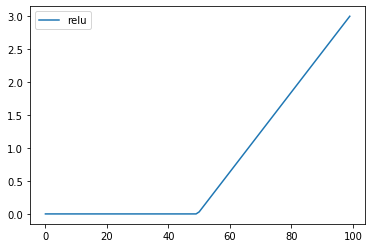

In [49]:
plt.plot(np.maximum(np.linspace(-3, 3, 100), 0), label="relu")
plt.legend(loc="best")
plt.show()

In [50]:
def relu(Z):
    """
    Arguments:
    Z -- Output of the linear layer 
    
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

In Neural Network, it usually solve multi-class classification problem by involving 
**softmax** and **cross entropy** loss function in stead of working on OvO or OVA. Thus, we define it as below:  
1. $$\text{cross entropy loss} =   - {\sum_{i} y_i \log\left( a_i \right) }.$$
2. $$\text{softmax} (z)_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}, \quad i=1,\dots,K, \quad z=(z_1,\dots,z_k) \in \mathbb{R}^k.$$



In [51]:
def softmax(Z):
    """
    softmax activation
    Arguments:
    Z -- numpy array of any shape

    Returns:
    A -- output of softmax(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    Z_shift = Z - np.max(Z, axis = 0)
    A = np.exp(Z_shift)/ np.sum(np.exp(Z_shift), axis=0)
    cache = Z_shift
    return A, cache

**Cross entropy loss function**

In [52]:
def compute_cost(AL, Y):
    """
    Arguments:
    AL -- probability matrix corresponding to your label predictions, shape (classes, number of examples)
    Y -- true "label" matrix, shape (classes, number of examples)

    Returns:
    cost -- softmax cross-entropy cost
    """
    m = Y.shape[1]
    cost = -(np.sum(Y * np.log(AL))) / float(m)
    return cost

**Parameter initialization**  
To start training, we need to choose initial values for the weights and biases.
An initialization for the weights and the biases with all being equal to zero will lead all hidden neurons to have the same weights. Starting instead with large weights often leads to poor solutions. So, we will initialize the weights and biases close to zero by using a Gaussian distribution with mean 0 and variance 1.
Note that in our shallow network, we only specify the weights and biases for two layers and we do not set biases for the input layer.

In [53]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)
    
    W1 = np.random.randn(n_h, n_x) * 0.01   # weight matrix random init
    b1 = np.zeros((n_h, 1))                 # bias vector random init
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

**Forward propagation module**  
The linear forward module (vectorized over all the examples) computes the following equations:
$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$
where $A^{[0]} = X$.

In [54]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

Implement the forward propagation of the LINEAR->ACTIVATION layer. Mathematical relation is:  
$$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$
where the activation "g" can be softmax() or relu().

In [55]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "softmax" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "softmax":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
      
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    return A, cache

**Backward propagation**

In [56]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T) / float(m)
    db = np.sum(dZ, axis=1, keepdims=True) / float(m)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    return dZ

def softmax_backward(Y, cache):
    """
    dL/dZ = （dL/dA） * （dA/dZ）

    Arguments:
    Y -- true "label" matrix, shape (classes, number of examples)
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    Z = cache  #Z_shift
    s = np.exp(Z)/ np.sum(np.exp(Z), axis=0)
    dZ = s - Y
    return dZ

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for hidden layer or Y for outputlayer!!!
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
 
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

**Parameters update**  

In [57]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(1,L+1):
        parameters['W'+str(l)] -= learning_rate * grads['dW'+str(l)]
        parameters['b'+str(l)] -= learning_rate * grads['db'+str(l)]
    return parameters

**Stochastic gradient descent**

We can also apply the SGD algorithm to neural network.  Unlike a fixed learning rate as we considered in convex problems, in SGD setting, it is better to use **adaptive learning rate** with variable step sizes $\eta_i$. Our attempt will be with fixed learning rate $\eta$.
 
Other techniques like mini-batch SGD can also be applied. 

$\quad $ **mini-batch SGD for MLP**:

**Input**: Training dataset $(x_1, y_1), \ldots, (x_n, y_n)$, batch size, learning rate $\eta$, number of iterations $\tau$.

**Initialize**: Choose the initial weights $w^{(1)}$ and the biases $b^{(1)}$ at random (from a distribution such that the values are close enough to $0$).

**for** $i = 1, 2, 3, \ldots, \tau$:

$\quad$ Choose a subset $K$ uniformly at random from $\{1, 2, \ldots, n\}$.

$\quad$ Calculate the gradients $\nabla_{w^{(i)}}, \nabla_{b^{(i)}} = \text{backpropagation}(x_K, y_K, w^{(i)}, b^{(i)})$.

$\quad$ Update \begin{align} w^{(i+1)} &= w^{(i)} - \eta (\nabla_{w^{(i)}} + \lambda w^{(i)}), \\ b^{(i+1)} &= b^{(i)} - \eta \nabla_{b^{(i)}}. \end{align}

**return**: parameters $w, b$

**Model integration**

In [58]:
def shallow_NN_mini_batch_train(X, Y, layers_dims, batch_size = None, learning_rate = 0.1, num_iterations = 3000, print_cost=False, plot=True, seed =None):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label", of shape (classes, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    batch_size -- None for all,
                  or input at the range of 2 to (number of samples -1)
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
#     np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m,d = X.shape                           #  number of examples, dimension
    (n_x, n_h, n_y) = layers_dims
#     batch_sample_size = m//10
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        if (batch_size !=None) and (batch_size < m) and (batch_size>1):
            sam_set=set()
            while len(sam_set)<batch_size:
                random_index = np.random.randint(0, m)  
                sam_set.add(random_index)

            sam_idx = list(sam_set)
            X_sam = X[sam_idx,:].T
            Y_sam = Y[sam_idx,:].T
        else:
            X_sam = X.T
            Y_sam = Y.T
        
        # Forward propagation: LINEAR -> RELU -> LINEAR -> SOFTMAX. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X_sam, W1, b1, activation='relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation='softmax')

        # Compute cost
        cost = compute_cost(A2, Y_sam)
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        dA1, dW2, db2 = linear_activation_backward(Y_sam, cache2, activation='softmax')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation='relu')
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 200 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if  i % 100 == 0:
            costs.append(cost)
    
    if plot:
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cross entropy loss')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    return parameters

In [59]:
def convert_to_onehot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [60]:
def shallow_NN_predict(X, parameters, probablity=True):
    """
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    predict_label -- predictions for the given dataset X
    """
    m,d = X.shape
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Forward propagation
    A1, _ = linear_activation_forward(X.T, W1, b1, activation='relu')
    probs, _ = linear_activation_forward(A1, W2, b2, activation='softmax')
    
    if probablity:
        return probs
    else:
        # convert probas to class label
        return np.argmax(probs, axis=0)
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
#     print("Accuracy: "  + str(np.sum((predict_label == y)/float(m))))
#     return predict_label

Now we have finished building all of our models. We need to validation models and find best parameters.

# Validation
**10 Fold**

In [61]:
n_fold=10

We define the loss function to evaluate how our model performs:
+ the 0-1 loss (percentage of wrong labels)

Alternatively, one could also try log-loss function, defined as : $ \tilde{L}(y, y') =   - \left[ y \log\left( y' \right) + (1 - y) \log\left( 1 - y'\right) \right], \quad y\in \{0,1\}, y' \in (0,1) $

In [62]:
def zero_one_loss(y_true, y_pred):
    n = y_true.shape[0]
    return (1/n) * np.sum(y_true != y_pred)

def log_loss(y_true, y_pred):
    n = y_true.shape[0]
    result = np.zeros(n)
    y_zero = y_true == 0
    result[y_zero] = -np.log(1-y_pred[y_zero])
    y_one = y_true == 1
    result[y_one] = -np.log(y_pred[y_one])
    return np.mean(result)

def error_plot(para_list, train_list, test_list,  x_label):
    plt.plot(para_list,train_list, "blue", label = "train error")
    plt.plot(para_list,test_list, "red", label = "test error")
    plt.xlabel(x_label)
    plt.ylabel('zero-one Loss')
    plt.legend()
    plt.show()    


### Cross Validation for Model 1: Decision Tree 
In the decision tree model, the hyper-parameters includes max_depth, min_samples_split and etc. The one with the most significant impact is max_depth. The others such as max_leaf_nodes and etc has similar effect as max_depth on controlling the complexity of the model. Thus, we only cross validate the model on max_depth to find the best value.  
Recall that we had roughly 248 to 273 sample points in our binary classification problems. Hence, our decision tree should less deep that $\log_2(273) \approx 8$.

In [62]:
max_depth_list = list(range(1,10))
max_depth_te_loss = []
max_depth_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in max_depth_list:
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(df_train):
        cv_train = df_train.iloc[train_index]
        cv_test = df_train.iloc[test_index]
        DTree_clf_list = myDecisionTreeCLF_train(cv_train, max_depth=i)

        cv_train_pred = myDecisionTreeCLF_predict(cv_train, DTree_clf_list,probablity=False)        
        cv_test_pred = myDecisionTreeCLF_predict(cv_test, DTree_clf_list,probablity=False)
        train_loss += zero_one_loss(cv_train.iloc[:,-1:].values, cv_train_pred.reshape(len(cv_train_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, cv_test_pred.reshape(len(cv_test_pred),1))
    max_depth_te_loss.append(test_loss/n_fold)
    max_depth_tr_loss.append(train_loss/n_fold)   

**Training and test error plot**

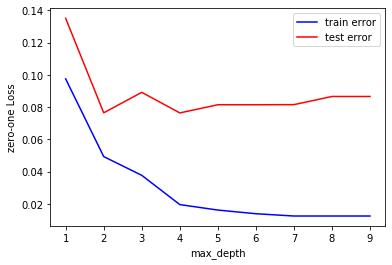

In [63]:
error_plot(max_depth_list,max_depth_tr_loss,max_depth_te_loss,x_label='max_depth')

From our cross validation, the best max_depth is **4**, when the value is increaseing, the model is start to overfit.

### Cross Validation for Model 2: Random Forest

In Random forest, the hyper-parameters we can fine tune includes n_estimators, max_features, max_depth and etc. We pick **n_estimators** and **max_features** here because they are more important than others.

In [63]:
n_estim_list = list(range(5,35,5))
n_estim_tr_loss = []
n_estim_te_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in n_estim_list:
    train_loss=0
    test_loss=0
    for train_index, test_index in rkf.split(df_train):
        cv_train=df_train.iloc[train_index]
        cv_test=df_train.iloc[test_index]
        
        RF_clf_list = myRandomForestCLF_train(cv_train, n_estimators=i)
        RF_tr_pred = myRandomForestCLF_predict(cv_train, RF_clf_list, rf_probablity=False)
        RF_te_pred = myRandomForestCLF_predict(cv_test, RF_clf_list, rf_probablity=False)        
        train_loss +=zero_one_loss(cv_train.iloc[:,-1:].values, RF_tr_pred.reshape(len(RF_tr_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, RF_te_pred.reshape(len(RF_te_pred),1))
    n_estim_tr_loss.append(train_loss/n_fold)
    n_estim_te_loss.append(test_loss/n_fold)

**Training and test error plot**

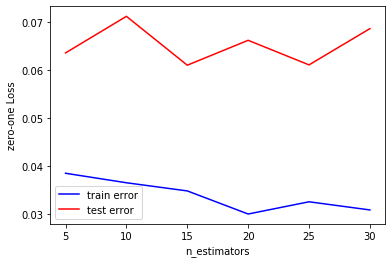

In [65]:
error_plot(n_estim_list, n_estim_tr_loss,n_estim_te_loss,x_label='n_estimators')

The best n_estimator is **15**, when the value is increaseing, the model is start to overfit.

In [64]:
max_feature_list = list(range(3,13))
max_feature_tr_loss = []
max_feature_te_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in max_feature_list:
    train_loss=0
    test_loss=0
    for train_index, test_index in rkf.split(df_train):
        cv_train=df_train.iloc[train_index]
        cv_test=df_train.iloc[test_index]
        
        RF_clf_list = myRandomForestCLF_train(cv_train,n_estimators=10, max_features=i)
        RF_tr_pred = myRandomForestCLF_predict(cv_train, RF_clf_list, rf_probablity=False)
        RF_te_pred = myRandomForestCLF_predict(cv_test, RF_clf_list, rf_probablity=False)        
        train_loss +=zero_one_loss(cv_train.iloc[:,-1:].values, RF_tr_pred.reshape(len(RF_tr_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, RF_te_pred.reshape(len(RF_te_pred),1))
    max_feature_tr_loss.append(train_loss/n_fold)
    max_feature_te_loss.append(test_loss/n_fold)

**Training and test error plot**

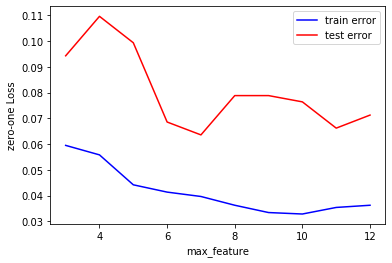

In [67]:
error_plot(max_feature_list, max_feature_tr_loss,max_feature_te_loss,x_label='max_feature')

The best max_features is **7**, when the value is increaseing, the model is start to overfit.

If one is using sklearn to cross validate on **multiple parameter combinations**, the GridSearchCV method is recommended. In our case, it is not neccessary. 

In [65]:
# from sklearn.model_selection import GridSearchCV

# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [5, 10],
#     'n_estimators': [100, 200, 300, 1000]
# }

# # Create a based model
# rf = RandomForestRegressor()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

### Cross Validation for Model 3: GradientBoosting
In GradientBoosting, hyperparameters includes **min_samples_split**, **max_depth**, **n_estimators** and etc.    Since GradientBoosting classifier is similar to Random Forest to some extend, we will just fine tune on **n_estimators** to compare how the results differ between bagging and boosting strategy. 

In [66]:
n_estim_list = list(range(10, 100, 10))
n_estim_te_loss = []
n_estim_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in n_estim_list:
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(df_train):
        cv_train = df_train.iloc[train_index]
        cv_test = df_train.iloc[test_index]
        GB_clf_list = myGradientBoostingCLF_train(cv_train, n_estimators=i)

        GB_train_pred = myGradientBoostingCLF_predict(cv_train, GB_clf_list,probablity=False)        
        GB_test_pred = myGradientBoostingCLF_predict(cv_test, GB_clf_list,probablity=False)
        
        train_loss += zero_one_loss(cv_train.iloc[:,-1:].values, GB_train_pred.reshape(len(GB_train_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, GB_test_pred.reshape(len(GB_test_pred),1))
    n_estim_te_loss.append(test_loss/n_fold)
    n_estim_tr_loss.append(train_loss/n_fold)   

**Training and test error plot**

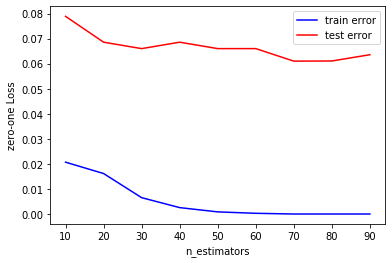

In [70]:
error_plot(n_estim_list, n_estim_tr_loss,n_estim_te_loss,x_label='n_estimators')

From our cross validation, we can see that the best n_estimators is **30**, when the value is increaseing, the model is start to overfit.

### Cross Validation for Model 4: Support Vector Machine(SVM)
In Support Vector Machine, hyperparameters includes C(regularization) , kernel and etc. **We directly choose 'rbf' kernel** because our data set is not very large. Therefore, only C is cross-validated here.

In [67]:
c_list = [0.0001,0.001,0.01,1,10,100,1000]
c_te_loss = []
c_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in c_list:
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(df_train_scale):
        cv_train = df_train_scale.iloc[train_index]
        cv_test = df_train_scale.iloc[test_index]
        SVM_clf_list = mySVMCLF_train(cv_train, C =i)

        SVM_train_pred = mySVMCLF_predict(cv_train, SVM_clf_list,probablity=False)        
        SVM_test_pred = mySVMCLF_predict(cv_test, SVM_clf_list,probablity=False)

        train_loss += zero_one_loss(cv_train.iloc[:,-1:].values, SVM_train_pred.reshape(len(SVM_train_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, SVM_test_pred.reshape(len(SVM_test_pred),1))
    c_te_loss.append(test_loss/n_fold)
    c_tr_loss.append(train_loss/n_fold)   

**Training and test error plot**

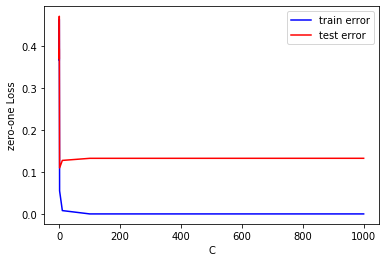

In [72]:
error_plot(c_list, c_tr_loss,c_te_loss,x_label='C')

From our cross validation, the best C is **1**, when the value is increaseing, the model is start to overfit.

### Cross Validation for Model 5: K-nearest neighbors(KNN)

In the K-nearest neighbors model, K is the primary hyper-parameter to tune. K is better to be odd number. If k is an even number, the exact class of the new point is difficult to predict when its two neighbors are disagree with each other.

In [68]:
neighbors_list = [3,5,7,9,11,15,21]
neighbors_te_loss = []
neighbors_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in neighbors_list:
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(df_train_scale):
        cv_train = df_train_scale.iloc[train_index]
        cv_test = df_train_scale.iloc[test_index]
        KNN_clf_list = myKNNCLF_train(cv_train, n_neighbors=i)

        KNN_train_pred = myKNNCLF_predict(cv_train, KNN_clf_list, probablity=False)        
        KNN_test_pred = myKNNCLF_predict(cv_test, KNN_clf_list, probablity=False)
        train_loss += zero_one_loss(cv_train.iloc[:,-1:].values, KNN_train_pred.reshape(len(KNN_train_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, KNN_test_pred.reshape(len(KNN_test_pred),1))
    neighbors_te_loss.append(test_loss/n_fold)
    neighbors_tr_loss.append(train_loss/n_fold)   

**Training and test error plot**

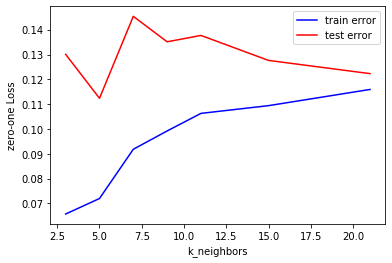

In [74]:
error_plot(neighbors_list,neighbors_tr_loss,neighbors_te_loss,x_label='k_neighbors')

From our cross validation, we can see that the best n_neighbors is **5**, when the value is increaseing, the model is start to overfit.

### Cross Validation for Model 6: Logistic Regression
In logistic regression, the hyperparameters we need to tune is regularization parameter C, $C = \frac{1}{\lambda}$.
The smaller the C, the stronger the effect of regularization; the bigger the C, the poor the effect of regularization.

In [69]:
regular_list = [0.0001,0.001,0.01,1,10,100,1000]
regular_te_loss = []
regular_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
for i in regular_list:
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(df_train_scale):
        cv_train = df_train_scale.iloc[train_index]
        cv_test = df_train_scale.iloc[test_index]
        LR_clf_list = myLogisticRCLF_train(cv_train, C=i)

        LR_train_pred = myLogisticRCLF_predict(cv_train, LR_clf_list, probablity=False)        
        LR_test_pred = myLogisticRCLF_predict(cv_test, LR_clf_list, probablity=False)
        train_loss += zero_one_loss(cv_train.iloc[:,-1:].values, LR_train_pred.reshape(len(LR_train_pred),1))
        test_loss += zero_one_loss(cv_test.iloc[:,-1:].values, LR_test_pred.reshape(len(LR_test_pred),1))
    regular_te_loss.append(test_loss/n_fold)
    regular_tr_loss.append(train_loss/n_fold)   

**Training and test error plot**

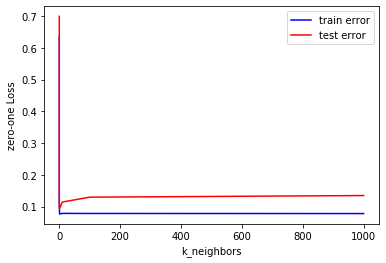

In [76]:
error_plot(regular_list,regular_tr_loss,regular_te_loss,x_label='k_neighbors')

From our cross validation, we can see that the best C is **1**.

### Cross Validation for Model 7: Neural Network

we basically interested in these hyperparameters: **network architecture**, **learning rate** and **number of iterations**.

we use Data set:**df_train_scale** and **df_test_scale** and convert label into one-hot encoding before input into our network.

In [63]:
X_scale_tr = df_train_scale.iloc[:,:-1].values
Y_tr = df_train_scale.iloc[:,-1:].values
Y_tr_OH = convert_to_onehot(Y_tr.astype(int),3)
(X_scale_tr.shape , Y_tr_OH.shape)

((392, 13), (392, 3))

learning rate: **small vs medium vs large**

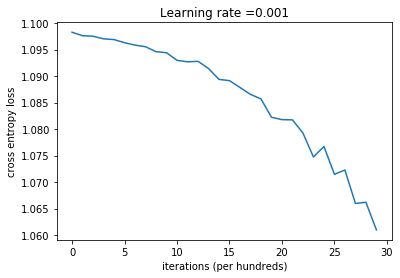

time: 2.092231035232544


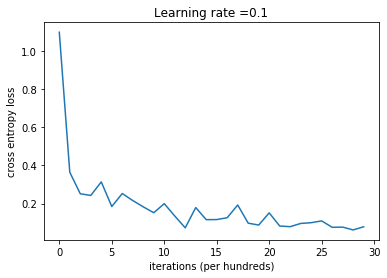

time: 2.085754871368408


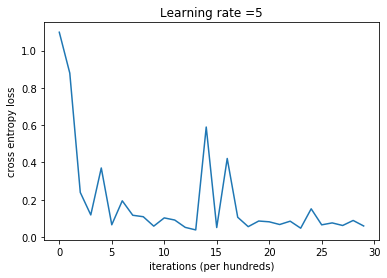

time: 2.823997974395752


In [69]:
lr_list = [0.001,0.1,5]
for lr in lr_list:
    start = time.time()
    paras = shallow_NN_mini_batch_train(X_scale_tr, Y_tr_OH, batch_size = 100,learning_rate = lr,
                                    layers_dims = (13, 80, 3), num_iterations = 3000, print_cost=False)
    print("time:",time.time()-start)

Small learning rate may converge slowly, but large learning rate might oversight. **We set our learning_rate at 0.1**.

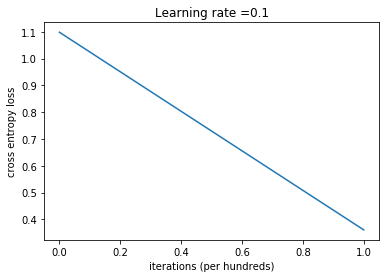

time: 0.3668339252471924


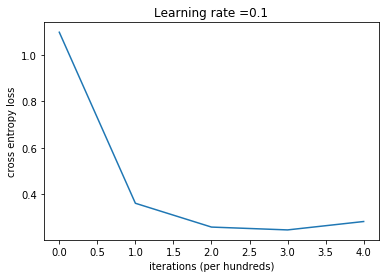

time: 0.751378059387207


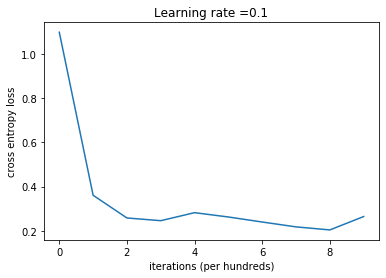

time: 1.1131410598754883


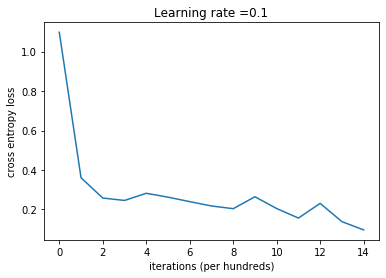

time: 1.3686668872833252


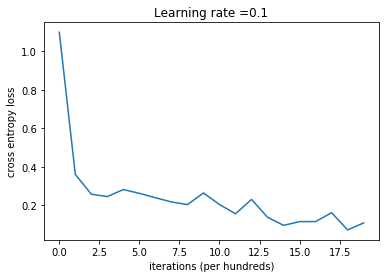

time: 1.605848789215088


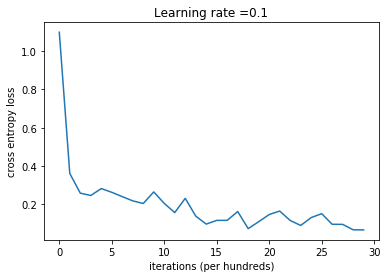

time: 2.1260411739349365


In [79]:
# number of iterations
iter_list = [200,500,1000,1500,2000,3000]
for itr in iter_list:
    start = time.time()
    paras = shallow_NN_mini_batch_train(X_scale_tr, Y_tr_OH, batch_size = 100,learning_rate = 0.1,
                                    layers_dims = (13, 80, 3), num_iterations = itr, print_cost=False)
    print("time:",time.time()-start)

It does not mean that large iteration is necessarily better.  Usually, large iteration will lead to overfit. However, if the iteration is too small, the network will not learn well. From the graph, **set iterations as 1000 is enough**.

**network architecture: number of neurons in the hidden layer**

In [98]:
architecture_list = [(13, 5, 3),(13, 50, 3),(13, 200, 3),
                     (13, 500, 3),(13, 800, 3),(13, 1200, 3),
                     (13, 1600, 3),(13, 2200, 3),(13, 3000, 3)]
arch_te_loss = []
arch_tr_loss = []
rkf = KFold(n_splits=n_fold, shuffle=False, random_state=None)
neurons_list=[]
for arch in architecture_list:
    print("architecture is:",arch)
    neurons_list.append(arch[1])
    test_loss=0
    train_loss=0
    for train_index, test_index in rkf.split(X_scale_tr):
        cv_train = X_scale_tr[train_index]
        cv_Y_tr_OH = Y_tr_OH[train_index]
        cv_test = X_scale_tr[test_index]
        cv_Y_te_OH = Y_tr_OH[test_index]
        NNclf = shallow_NN_mini_batch_train(cv_train, cv_Y_tr_OH, batch_size = 100,learning_rate = 0.1,
                                    layers_dims = arch, num_iterations = 1000, print_cost=False, plot= False)
        NN_train_pred = shallow_NN_predict(cv_train, NNclf, probablity=False)
        NN_test_pred = shallow_NN_predict(cv_test, NNclf, probablity=False)
        train_loss += zero_one_loss(Y_tr[train_index], NN_train_pred.reshape(len(NN_train_pred),1))
        test_loss += zero_one_loss(Y_tr[test_index], NN_test_pred.reshape(len(NN_test_pred),1))
    arch_tr_loss.append(train_loss/n_fold)
    arch_te_loss.append(test_loss/n_fold)   

architecture is: (13, 5, 3)
architecture is: (13, 50, 3)
architecture is: (13, 200, 3)
architecture is: (13, 500, 3)
architecture is: (13, 800, 3)
architecture is: (13, 1200, 3)
architecture is: (13, 1600, 3)
architecture is: (13, 2200, 3)
architecture is: (13, 3000, 3)


**Training and test error plot**

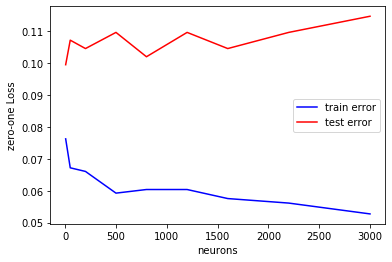

In [99]:
error_plot(neurons_list,arch_tr_loss,arch_te_loss,x_label='neurons')

It does not mean that more neurons is necessarily better.  Usually, more neurons will lead to overfit. However, fewer neurons may not be sufficiently representative. From the graph, **set 200 neurons in the hidden layer should be enough**.

# Testing
After Cross validation, we will predict our optimized models on the test set and see how each model performs. 

In [82]:
X_scale_tr = df_train_scale.iloc[:,:-1].values
Y_tr = df_train_scale.iloc[:,-1:].values
Y_tr_OH = convert_to_onehot(Y_tr.astype(int),3)
X_scale_te = df_test_scale.iloc[:,:-1].values
Y_te = df_test_scale.iloc[:,-1:].values
Y_te_OH = convert_to_onehot(Y_te.astype(int),3)

In [89]:
NNclf = shallow_NN_mini_batch_train(X_scale_tr, Y_tr_OH, batch_size = 100,learning_rate = 0.1,
                                    layers_dims = (13,500,3), num_iterations = 1000, print_cost=False, plot= False)
NN_pred_prob = shallow_NN_predict(X_scale_te, NNclf, probablity=True)
NN_pred = shallow_NN_predict(X_scale_te, NNclf, probablity=False)
NN_loss = zero_one_loss(Y_te, NN_pred.reshape(len(NN_pred),1))

In [77]:
DTree_clf_list = myDecisionTreeCLF_train(df_train, max_depth=4)
DTree_pred_prob = myDecisionTreeCLF_predict(df_test,DTree_clf_list,probablity=True)
DTree_pred = myDecisionTreeCLF_predict(df_test,DTree_clf_list,probablity=False)
DTree_loss = zero_one_loss(df_test.iloc[:,-1:].values, DTree_pred.reshape(len(DTree_pred),1))

RF_clf_list = myRandomForestCLF_train(df_train, n_estimators=15, max_features=7)
RF_pred_prob = myRandomForestCLF_predict(df_test, RF_clf_list,rf_probablity=True)
RF_pred = myRandomForestCLF_predict(df_test, RF_clf_list,rf_probablity=False)
RF_loss = zero_one_loss(df_test.iloc[:,-1:].values, RF_pred.reshape(len(RF_pred),1))

GB_clf_list = myGradientBoostingCLF_train(df_train, n_estimators=30)
GB_pred_prob = myGradientBoostingCLF_predict(df_test,GB_clf_list,probablity=True)
GB_pred = myGradientBoostingCLF_predict(df_test,GB_clf_list,probablity=False)
GB_loss = zero_one_loss(df_test.iloc[:,-1:].values, GB_pred.reshape(len(GB_pred),1))

SVM_clf_list = mySVMCLF_train(df_train_scale, C = 1)
SVM_pred_prob = mySVMCLF_predict(df_test_scale,SVM_clf_list,probablity=True)                                       
SVM_pred = mySVMCLF_predict(df_test_scale,SVM_clf_list,probablity=False)
SVM_loss = zero_one_loss(df_test_scale.iloc[:,-1:].values, SVM_pred.reshape(len(SVM_pred),1))

KNN_clf_list = myKNNCLF_train(df_train_scale, n_neighbors = 5)
KNN_pred_prob = myKNNCLF_predict(df_test_scale,KNN_clf_list,probablity=True)                                       
KNN_pred = myKNNCLF_predict(df_test_scale,KNN_clf_list,probablity=False)
KNN_loss = zero_one_loss(df_test_scale.iloc[:,-1:].values, KNN_pred.reshape(len(KNN_pred),1))

LR_clf_list = myLogisticRCLF_train(df_train_scale, C= 1.0)
LR_pred_prob = myLogisticRCLF_predict(df_test_scale, LR_clf_list,probablity=True)                                       
LR_pred = myLogisticRCLF_predict(df_test_scale, LR_clf_list,probablity=False)
LR_loss = zero_one_loss(df_test_scale.iloc[:,-1:].values, LR_pred.reshape(len(LR_pred),1))

In [102]:
print('The losses for each model are:\n',[DTree_loss, RF_loss, GB_loss, SVM_loss, KNN_loss, LR_loss,NN_loss])

The losses for each model are:
 [0.030612244897959183, 0.04081632653061224, 0.030612244897959183, 0.061224489795918366, 0.1020408163265306, 0.07142857142857142, 0.061224489795918366]


#### Ensemble Learning
Ensemble learning helps improve machine learning results by combining several models. This approach allows the production of better predictive performance compared to a single model.  
Since we already have 7 classifiers, we can ensemable them and see if it produce better result.

**Soft Vote**

In [103]:
ensemble_pred_prob = np.divide((DTree_pred_prob + RF_pred_prob+ GB_pred_prob + SVM_pred_prob 
                                       + KNN_pred_prob + LR_pred_prob+NN_pred_prob.T),7)
ensemble_pred = np.argmax(ensemble_pred_prob, axis = 1)    
Ensemble_soft_loss = zero_one_loss(df_test_scale.iloc[:,-1:].values, ensemble_pred.reshape(len(ensemble_pred),1))
print('Ensemble train 0-1 loss:', Ensemble_soft_loss)

Ensemble train 0-1 loss: 0.04081632653061224


**Hard Vote**

In [104]:
ensemble_pred_vote = np.divide((convert_to_onehot(DTree_pred,3) + 
                                convert_to_onehot(RF_pred,3) +
                                convert_to_onehot(GB_pred,3) +
                                convert_to_onehot(SVM_pred,3) +
                                convert_to_onehot(KNN_pred,3) +
                                convert_to_onehot(LR_pred,3) +
                                convert_to_onehot(NN_pred.T,3)),7) 
ensemble_label=np.argmax(ensemble_pred_vote, axis = 1)  
Ensemble_hard_loss = zero_one_loss(df_test_scale.iloc[:,-1:].values, ensemble_label.reshape(len(ensemble_label),1))
print('Ensemble train 0-1 loss:', Ensemble_hard_loss)

Ensemble train 0-1 loss: 0.0510204081632653


# Conclusion

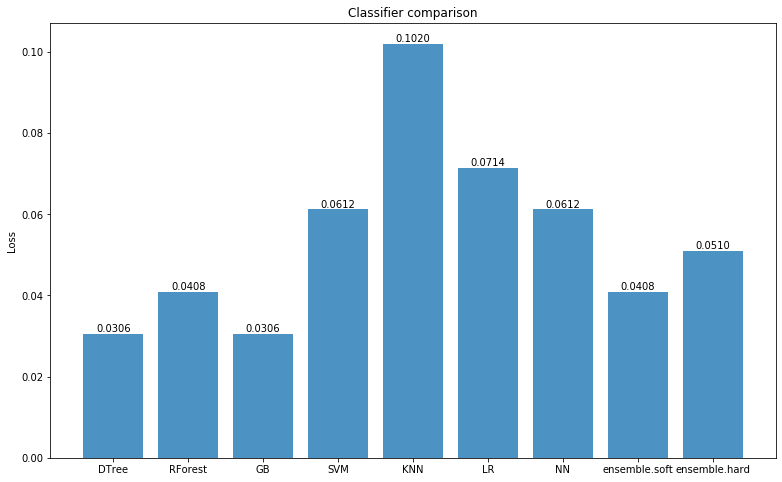

In [107]:
objects = ('DTree', 'RForest', 'GB', 'SVM', 'KNN', 'LR','NN', 'ensemble.soft','ensemble.hard')
x_pos = np.arange(len(objects)) 
loss = [DTree_loss, RF_loss, GB_loss, SVM_loss, KNN_loss, LR_loss,NN_loss, Ensemble_soft_loss,Ensemble_hard_loss]

plt.figure(figsize=(13,8))

plt.bar(x_pos, loss, align = 'center', alpha=0.8)
for clf, res in zip(x_pos, loss):
    plt.text(clf, res, '%.4f'%res, ha='center', va='bottom', fontsize=10)

plt.xticks(x_pos, objects)
plt.ylabel('Loss')
plt.title('Classifier comparison')

plt.show()

The above graph shows the final loss of our models. From our result, decision tree and gradient boosting perform the best. The losses are the same: 0.0306. The worst is KNN, which is 0.1327. Ensemble classifiers are better than average. The results of soft voting(0.0510) and hard voting(0.0408) are slightly different but both better than average.